## Exercício: Modelo de Linguagem com auto-atenção e máscaras causais

> Seguimos na mesma linha de treinar um modelo de linguagem a partir dos textos do livro "O Guarani", de José de Alencar.
> 
> Neste exercício, vamos treinar um modelo de linguagem com auto-atenção e com máscara causal. A máscara causal é necessária para que o modelo não tenha acesso a palavras futuras, que é a abordagem usada por grandes modelos de linguagem, como o GPT.
> 
> Use a implementação matricial de auto-atenção da aula passada.
> 
> ### Modificações necessárias
> 
> - [x] Adicione a máscara causal na função `forward` da cabeça de auto-atenção.
> - [x] Modifique o nosso dataloader para retornar inputs (uma lista de tokens de tamanho $n$), targets (uma lista de tokens de tamanho $n$ deslocada para a esquerda em 1 token). Exemplo `input = [1, 2, 3, 4]`, `target = [2, 3, 4, 5]` para a sequência `[1, 2, 3, 4, 5]` com `seq_len=4`, por exemplo (Ver slide 50).
> 
> ### Extra
> - [x] MultiHeadAttention: modifique a cabeça de auto-atenção para ter múltiplas cabeças. Isso não é obrigatório, mas pode ser interessante para ver como o modelo se comporta.
> - [ ] Diagrama da geração: fazer diagrama que mostre os passos da geração de tokens (conforme slide 47).
> 
> ### Dicas
> 
> * Use como base o vídeo do Karpathy: https://www.youtube.com/watch?v=kCc8FmEb1nY. Observe que, no vídeo, ele primeiro implementa um modelo bi-grama, depois um modelo de linguagem com auto-atenção. O modelo de auto-atenção é implementado por volta do minuto 40, mas vale a pena assistir o vídeo todo.
> * Use esta implementação como base: https://colab.research.google.com/drive/1vFTg4MSXVJwNSzPjaCcvmqhxTP7gK7HA?usp=sharing. Observe como o modelo é organizado e como a máscara é implementada na classe MultiHeadAttention.
> * Use `context_size=9`

Este notebook irá mostrar o processo de criação de um modelo de linguagem utilizando um transformer decoder-only, com processo de atenção multi-cabeça e máscara causal.

Iremos começar importando os módulos que serão utilizados na atividade:

In [248]:
import string # Manipular strings
from collections import Counter # Fazer contagem de elementos
import random # Operações randômicas
import os # Manipular arquivos
import time # Medição de tempo
import abc # Classes abstratas
import itertools # Iterators
from typing import List, Dict, Union, Tuple # Type hints

import numpy as np # Operações vetoriais
from numpy.testing import assert_raises, assert_array_equal, assert_array_almost_equal # Testes
from numpy.typing import ArrayLike # Type hints
import torch # ML
from torch.utils.data import Dataset, DataLoader # Preparação de dados
import matplotlib.pyplot as plt # Plots
import wandb # Logging

E algumas funções auxiliares que serão utilizadas:

In [249]:
def assert_array_not_equal(array1:ArrayLike, array2:ArrayLike) -> None:
    """
    Raises an AssertionError if two array_like objects are equal.

    Args:
        array1 (ArrayLike): First array to check.
        array2 (ArrayLike): Second array to check.
    """
    assert_raises(AssertionError, assert_array_equal, array1, array2)

In [250]:
def reset_seeds() -> None:
    """
    Resets the random generators from random and torch to a fixed seed.
    """
    random.seed(18)
    torch.manual_seed(18)

## Preparação dos dados.

Nesta seção serão definidas funções para preparar os dados para treino do modelo. Devido a necessidade de alterar os parâmetros constantemente durante os experimentos de treino, são definidas em funções as operações que são necessárias. Exemplos são executados para mostrar o funcionamento correto das operações.

### Faz download e carrega o dataset

Nesta seção os dados serão transferidos, lidos e limpos.

O primeiro passo é realizar o download dos dados:

In [251]:
if not os.path.isfile("67724.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67724.txt.utf-8

if not os.path.isfile("67725.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67725.txt.utf-8

Seguido pela leitura:

In [252]:
text = open("67724.txt.utf-8","r", encoding="utf8").read()
text += open("67725.txt.utf-8","r", encoding="utf8").read()

paragraphs = text.split("\n\n")
len(paragraphs)

4971

E limpeza dos dados.

São realizadas as seguintes operações seguindo o paper "A Neural Probabilistic Language Model"


- Pontuação: é mantida, porém separada do texto para permitir criação de símbolos próprios no vocabulário, e evitar a criação de várias símbolos representando as palavras com pontuação ("pontuação" -> "pontuação" + "," )
- Número: convertidos para símbolo especial. No caso todos os números são convertidos para "999", para que convirjam para o mesmo símbolo no vocabulário
- Letras maiúsculas: convertidas para minúsculas.
- Nomes próprios: não são alterados devido a necessidade de serem identificados, diferente do paper.
- Palavras raras: são removidas ao criar o vocabulário.

In [253]:
def clean_text(text:str) -> str:
    '''
    Clean the text, changing upper case and setting numbers to 999.
    '''
    
    text = text.lower() # Upper Case -> lower case
    
    old_text = text.split()
    new_text = []

    for j in range(len(old_text)):
        word = old_text[j] 

        if word.isdigit(): #Number -> 999
            word = "999"
        elif len(word) > 1 and word[0] in string.punctuation: # Ponctuation -> separate
            old_text.insert(j+1, word[1:])
            word = word[0]
        elif word[-1] in string.punctuation and len(word) > 1: # Ponctuation -> separate
            old_text.insert(j+1, word[:-1])
            old_text.insert(j+2, word[-1])
            
            word = ""
        
        if len(word) > 0: # No empty words
            new_text.append(word)
    
    return " ".join(new_text)

In [254]:
cleaned_paragraphs = [paragraph.replace("\n", " ") for paragraph in paragraphs if paragraph.strip()] # Removes \n

for i in range(len(cleaned_paragraphs)):
    cleaned_paragraphs[i] = clean_text(cleaned_paragraphs[i])


Podemos ver um exemplo de parágrafo limpo do dataset, junto com a quantidade total de parágrafos obtidos:

In [255]:
print("SAMPLE ----------------")
print(cleaned_paragraphs[0])
print("---------------------")

print(len(cleaned_paragraphs))

SAMPLE ----------------
﻿the project gutenberg ebook of o guarany : romance brazileiro , vol . 999 ( of 999 ) this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever . you may copy it , give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org . if you are not located in the united states , you
---------------------
4892


### Análise do dataset

Aqui iremos realizar a contagem de palavras no dataset.

In [256]:
def count_words(texts:List[str]) -> Counter:
    """
    Counts the words in the texts.

    Args:
        texts (List[str]): List of strings with the texts.

    Returns:
        Counter: counter with the word count across all texts.
    """
    
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split(" "))
    return word_counts

word_counts = count_words(cleaned_paragraphs)

len(word_counts)

11470

### Criando um vocabulário

Com a contagem de palavras podemos definir uma função para criar um novo vocabulário:

In [257]:
def create_vocab(word_counts:Counter, vocab_size:int) -> Tuple[Dict[str, int], List[str]]:
    """
    Generates the vocabulary with the most frequent words.

    Args:
        word_counts (Counter): word count to generate vocabulary.
        vocab_size (int): maximum size for the vocabulary.

    Returns:
        Dict[str, int]: vocabulary mapping words to codes.
        List[str]: inverse vocabulary mapping codes to words.
    """


    most_frequent_words = [word for word, count in word_counts.most_common(vocab_size)]
    vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}

    inverse_vocab = list(vocab.keys())

    return vocab, inverse_vocab

E podemos executar um teste mostrando a geração de um vocabulário e suas primeiras 0 entradas:

In [258]:
test_vocab_size = 1000
test_vocab, test_inverse_vocab = create_vocab(word_counts, test_vocab_size)

In [259]:
list(itertools.islice(test_vocab.items(), 10))

[(',', 1),
 ('a', 2),
 ('que', 3),
 ('-', 4),
 ('o', 5),
 ('de', 6),
 ('e', 7),
 (';', 8),
 ('.', 9),
 ('um', 10)]

É interessante observar que as palavras mais frequentes são acentuações, o que pode dificultar o aprendizado de sentenças significativas.

### Codificando e Decodificando sentenças

Podemos utilizar as seguintes funções para codificar um texto e decodificá-lo:

In [260]:
def encode_sentence(sentence:Union[str,List[str]], vocab:Dict) -> List[int]:
    """
    Encodes a sentence using a vocabulary.

    Args:
        sentence (Union[str,List[str]]): sentence to encode. Or a string,
            or the string already separated into words
        vocab (Dict): vocabulary to encode. Maps words to codes.

    Returns:
        List[int]: the encoded sentence
    """
    if isinstance(sentence, list):
        words = sentence
    else:
        words = sentence.split(" ")
    
    return [vocab.get(word, 0) for word in words]

In [261]:
def decode_sentence(encoding:List[int], inverse_vocab:List[str]) -> List[str]:
    """
    Decodes a sentence back to words.

    Args:
        encoding (List[int]): encoded sentence to decode.
        inverse_vocab (List[str]): inverse vocabulary. Maps codes to words

    Returns:
        List[str]: decoded sentence. Unknown codes are decoded to '???' 
    """
    result = []

    for encoding_i in encoding:
        if encoding_i == 0:
            result.append("???")
        else:
            result.append(inverse_vocab[encoding_i-1])

    return result

### Separação e Classe do dataset

Aqui iremos definir as sentenças a partir dos textos; divídi-las em treino, teste e valiadação; e criar a classe para carregar os dados durante os experimentos.

Criamos as sequências com tamanhos `context_size+1`, visto que elas precisaram ser deslocadas para gerar os targets:

In [262]:
def create_sequences(texts:List[str], context_size:int, 
                     vocab:Dict) -> Tuple[List[List[int]], List[int]]:
    """
    Creates sequences from the texts, with the target (word to predict), 
    using a fixed size and vocabulary.

    Args:
        texts (List[str]): texts to create sequences.
        context_size (int): size of the sequences.
        vocab (Dict): maps words to codes.

    Returns:
        List[List[int]]: created sequences.
    """

    x_all = []

    for paragraph in texts:
        start = 0
        end = context_size+1

        paragraph = encode_sentence(paragraph, vocab)

        while end < len(paragraph):
            x = paragraph[start:end]
            y = paragraph[end]

            if not ( 0 in x or 0 == y):
                x_all.append(x)

            start += 1
            end += 1
            
    x_all = np.array(x_all)

    return x_all

Criamos um dataset de teste e validamos que as entradas e targets possuem o mesmo tamanho.

In [263]:
test_context_size = 10

test_x_all = create_sequences(cleaned_paragraphs, test_context_size, test_vocab)

In [264]:
assert len(test_x_all[0]) == test_context_size+1

Para evitar viéses, definimos uma função para embaralhar o dataset:

In [265]:
def shuffle_dataset(x:List) -> List[int]:
    """
    Shuffle the dataset.

    Args:
        x (List): dataset elements.

    Returns:
        List: shuffled elements. 
    """

    indexes = list(range(len(x)))
    random.shuffle(indexes)

    x = x[indexes]

    return x

In [266]:
test_x_all = shuffle_dataset(test_x_all)

E separamos os dados em treino (60%), validação (20%) e teste (20%):

In [267]:
def separate_dataset(x_all:List[int]) -> Tuple[List[int], List[int], List[int]]:
    """
    Separate the data in train, validation and test.

    Args:
        x_all (List[int]): all dataset elements.

    Returns:
        List[int]: train elements. 
        List[int]: validation elements.
        List[int]: test elements.
    """
    size_all = len(x_all)

    cut1 = int(0.6*size_all)
    cut2 = int(0.8*size_all)

    x_train = x_all[0:cut1]

    x_val = x_all[cut1:cut2]

    x_test = x_all[cut2:]

    return x_train, x_val, x_test

Separamos os conjuntos e demonstramos que a separação separa corretamente os dados:

In [268]:
test_x_train, test_x_val, test_x_test = separate_dataset(test_x_all)

In [269]:
assert len(test_x_train)+len(test_x_val)+len(test_x_test) == len(test_x_all)

assert len(test_x_train) == int(0.6*len(test_x_all))
assert (len(test_x_val) == np.floor(0.2*len(test_x_all)) or len(test_x_val) == np.ceil(0.2*len(test_x_all)))
assert (len(test_x_test) == np.floor(0.2*len(test_x_all)) or len(test_x_test) == np.ceil(0.2*len(test_x_all)))

Criamos a classe para manipular o dataset:

In [270]:
class TextPredictDataset(Dataset):
    """
    Text prediction dataset.

    Input: sequence of encoded words.
    Target: next word for the sequence.
    """
    
    def __init__(self, x_data:List[List[int]]) -> None:
        """
        Creates a new dataset.

        Args:
            x_data (List[List[int]]): dataset elements.

        """

        self._x_data = torch.tensor(x_data).type(torch.LongTensor)-1
        
        self._size = len(x_data)

    def __len__(self) -> int:
        """
        Gets the size of the dataset.

        Returns:
            int: dataset size.
        """

        return self._size

    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Gets a item of the dataset.

        Args:
            idx (int): data index.

        Returns:
            torch.Tensor: dataset input. 
            torch.Tensor: dataset target.
        """
        return self._x_data[idx][:-1], self._x_data[idx][1:]


Geramos um dataset de exemplo e mostramos que os elementos e tamanhos das entradas e saídas estão correto:

In [271]:
test_train_dataset = TextPredictDataset(test_x_train)

In [272]:
assert_array_equal(test_train_dataset[0][0].shape, [test_context_size])
assert_array_equal(test_train_dataset[0][1].shape, [test_context_size])

assert_array_equal(test_train_dataset[0][1][1:-1], test_train_dataset[0][1][1:-1])

Por fim, mostramos o uso de um DataLoader e mostramos que os dados possuem tamanhos corretos:

In [273]:
test_batch_size = 5

In [274]:
test_train_loader = DataLoader(test_train_dataset, batch_size=test_batch_size, shuffle=True)

In [275]:
test_data = next(iter(test_train_loader))

In [276]:
assert_array_equal(test_data[0].shape, [test_batch_size, test_context_size])
assert_array_equal(test_data[1].shape, [test_batch_size, test_context_size])

### Juntando tudo

Para o uso posterior, podemos juntar todas as funções criadas realizando o processo completo de geração do dataset:

In [277]:
def create_data_loaders(texts:List[str], vocab_size:int, context_size:int, batch_size:int) -> Tuple[Dict, List, DataLoader, DataLoader, DataLoader]:
    """
    Generates a text prediction dataset.

    Args:
        texts (List[str]): texts to generate the dataset.
        vocab_size (int): size of the vocabulary (know words).
        context_size (int): size of the sequences.
        batch_size (int): size of the batchs.

    Returns:
        Dict: vocabulary. Maps words to codes.
        List: inverse vocabulary. Maps codes to words.
        DataLoader: train DataLoader.
        DataLoader: validation DataLoader.
        DataLoader: test DataLoader.
    """

    word_counts = count_words(texts)
    vocab, inverse_vocab = create_vocab(word_counts, vocab_size)

    x_all = create_sequences(texts, context_size, vocab)
    
    x_all = shuffle_dataset(x_all)

    x_train, x_val, x_test = separate_dataset(x_all)

    train_dataset = TextPredictDataset(x_train)
    val_dataset = TextPredictDataset(x_val)
    test_dataset = TextPredictDataset(x_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return vocab, inverse_vocab, train_loader, val_loader, test_loader

## Model

Esta seção irá implementar o modelo que será treinado, começando pelas camadas de atenção, encoding posicional e embedding; seguindo pelo modelo em si e seu teste.

### Attention

A camada de atenção é implementada segundo descrito em "Attention Is All You Need". É implementada a versão com múltiplas cabeças de atenção e máscara causal.

In [278]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_dim:int, num_heads:int) -> None:
        """
        Creates the layer.

        Args:
            embed_dim (int): size of the embedding in the layer input and output.
        """
        super().__init__()
        
        self.embed_dim = embed_dim
        
        self.num_heads = num_heads
        self.head_dim = embed_dim//num_heads

        if self.head_dim * num_heads != embed_dim:
            raise ValueError(f"embed_dim must be divisible by num_heads ({embed_dim}/{num_heads} is not integer).")


        #Initialize weights

        #d_model = dv = dk = embed_dim
        #h = 1

        wQ = torch.Tensor(embed_dim, embed_dim) #embed, embed
        wK = torch.Tensor(embed_dim, embed_dim) #embed, dk
        wV = torch.Tensor(embed_dim, embed_dim) #embed, dv
        w0 = torch.Tensor(embed_dim, embed_dim) #embed, embed

        self.wQ = torch.nn.Parameter(wQ)
        self.wK = torch.nn.Parameter(wK)
        self.wV = torch.nn.Parameter(wV)
        self.w0 = torch.nn.Parameter(w0)

        self.register_buffer("dk_root", torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32)))

        for w in [self.wQ, self.wK, self.wV, self.w0]:
            torch.nn.init.kaiming_normal_(w)



    def forward(self, query:torch.Tensor, key:torch.Tensor, value:torch.Tensor, is_causal:bool=False) -> torch.Tensor:
        """
        Process the inputs using the attention process.

        Input tensors must be in [batch, sentence, embed] order.

        Args:
            query (torch.Tensor): queries tensor, are compared against the keys.
            key (torch.Tensor): keys tensor, represents the keys.
            value (torch.Tensor): values tensor.

        Returns:
            torch.Tensor: the layer output, the values pondered by the compability between the keys and queries.
        """

        #Check input
        if query.shape[2] != self.embed_dim:
            raise ValueError(f"Inputs must have embed dimension of {self.embed_dim} ({query.shape[2]} != {self.embed_dim})")

        #Get dimensions
        batch_size = query.shape[0]
        context_size = query.shape[1]

        #Linear input transformation
        #Transpose weights because PyTorch does that
        Q = query @ self.wQ.T
        K = key @ self.wK.T
        V = value @ self.wV.T

        #batch_size, sentence, embed
        # to
        #batch_size,  n_head, sentence, head_dim
        Q = Q.transpose(0,1).reshape(context_size, batch_size*self.num_heads, self.head_dim).transpose(0,1)
        K = K.transpose(0,1).reshape(context_size, batch_size*self.num_heads, self.head_dim).transpose(0,1)
        V = V.transpose(0,1).reshape(context_size, batch_size*self.num_heads, self.head_dim).transpose(0,1)
        #Now we have [
        # [batch0word0part0, batch0word1part0], 
        # [batch0word0part1, batch0word1part1],
        # [batch1word0part0, batch1word1part0], 
        # [batch1word0part1, batch1word1part1],
        #]
        
        scores = Q @ K.transpose(-2, -1) #K.permute(0,1,3,2)
        scores /= self.dk_root

        #Apply causal bias
        if is_causal:
            mask = torch.ones((context_size, context_size), dtype=torch.bool)
            mask = mask.tril() #Lower triangular is one
            mask = torch.bitwise_not(mask) #Upper triangular without diagonal is ones

            attention_bias = torch.zeros((context_size, context_size), device=query.device)
            attention_bias[mask] = -torch.inf
        
            scores += attention_bias


        probs = torch.softmax(scores, dim=-1)
        E = probs @ V

        #Return elements to correct place 
        E = E.reshape(batch_size, self.num_heads, context_size, self.head_dim)
        E = E.transpose(-3,-2)
        E = E.reshape(batch_size, context_size, self.embed_dim)
        #Now we have [
        #[batch0word0, batch0word1], 
        #[batch1word0, batch1word1]
        #]

        result = E @ self.w0.T 

        return result


    

Para testar a camadas implementada, podemos instanciar ela junto da implementação de referência do PyTorch, e certificar que as saídas das 2 camadas são as mesmas, dado os mesmos pesos e entradas.

Instaciamos as camadas:

In [279]:
test_embed_dim = 4
test_num_heads = 2
test_context_size = 3

our_version = MultiHeadAttention(test_embed_dim, num_heads=test_num_heads).eval()
torch_version = torch.nn.MultiheadAttention(test_embed_dim, num_heads=test_num_heads, bias=False, batch_first=True ).eval()

Igualamos todos os pesos:

In [280]:
wQ = our_version.wQ
wK = our_version.wK
wV = our_version.wV
w0 = our_version.w0

torch_version.in_proj_weight = torch.nn.Parameter(torch.concat((wQ, wK, wV)))
torch_version.out_proj.weight = w0

Geramos os dados de teste randomicamente:

In [281]:
test_data = torch.rand(2, test_context_size, test_embed_dim) #2 batchs, sequences of test_context_size words, embed_dim

Realizamos as operações com as camadas e verificamos se os resultados são os mesmos, com e sem causalidade:

In [282]:
attention_mask = torch.nn.Transformer.generate_square_subsequent_mask(test_context_size)

for is_causal in [False, True]:

    result_our = our_version(test_data, test_data, test_data, is_causal)

    if is_causal:
        result_torch, _ = torch_version(test_data, test_data, test_data, need_weights=False, is_causal=True, attn_mask=attention_mask)
    else:
        result_torch, _ = torch_version(test_data, test_data, test_data, need_weights=False)

    result_our = result_our.detach()
    result_torch = result_torch.detach()

    assert result_our.shape == result_torch.shape
    assert_array_almost_equal(result_our, result_torch, decimal=5)

Por fim, podemos comparar a performance entre as camadas utilizando a CPU.

A célula está comentada devido ao custo de executá-lo, porém os resultados estão disponíveis a seguir.

In [283]:
#%timeit our_version(test_data, test_data, test_data)
#%timeit torch_version(test_data, test_data, test_data, need_weights=False)

```
Our: 208 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Torch: 260 µs ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
```

Curiosamente a implementação do PyTorch é mais lenta, porém pode ser devido as maiores capacidades que possue e checagens que executa. É importante que ressaltar que esses resultados são apenas para a execução utilizando a CPU.

Comparado com o exercício anterior (sem multi-head) o custo de execução praticamente dobrou, possivelmente pelo custo de manipular a configuração dos dados na memória para realizar as operações.

### Positional Encoding

A camada de encoding posicional é implementada com funções periódicas, assim como o paper "Attention is All You Need":

In [284]:
class SinePositionalEncoding(torch.nn.Module):
    """
    Positional enconding using sine/cossine function.
    """
    def __init__(self, embed_dim:int, sequence_size:int) -> None:
        """
        Creates the layer.

        Args:
            embed_dim (int): embedding size in the input and output.
            sequence_size (int): size of the sequence in the input and output.
        """

        super().__init__()

        #Caches the positions encodings:
        position = torch.arange(sequence_size, dtype=torch.float32)
        expoent = 2.0*torch.arange(embed_dim, dtype=torch.float32)/embed_dim

        pe = torch.empty((sequence_size, embed_dim))

        pe.T[:] = position
        pe /= torch.pow(1e4, expoent)

        pe[:, 0::2] = torch.sin(pe[:, 0::2])
        pe[:, 1::2] = torch.cos(pe[:, 1::2])

        self.register_buffer("pe", pe)

    def forward(self, input_tensor:torch.Tensor) -> torch.Tensor:
        """
        Adds the positions encodings to the input.

        Args:
            input_tensor (torch.Tensor): input tensor to receive the positions encodings

        Returns:
            torch.Tensor: input + positional encoding.
        """
        output = input_tensor + self.pe

        return output
        

Testamos a camada utilizando uma entrada nula para verificar se as codificações estão corretas.

In [285]:
test_embed_dim = 5
test_sequence_size = 3

test_data = torch.zeros(2, test_sequence_size, test_embed_dim) #2 batchs, sequences of 3 words, embed_dim

positional_encoding = SinePositionalEncoding(test_embed_dim, test_sequence_size)

result = positional_encoding(test_data)

assert_array_equal(result[0], result[1]) #Correct operation across batchs
assert_array_not_equal(result[0, 0], result[0, 1]) #Different positions -> Different encodings
assert_array_not_equal(result[0,:,0], result[0,:,1]) #Different dimensions -> Different encodings
assert len(list(positional_encoding.parameters())) == 0 #No trainable parameters

### Embedding

Para o embedding utilizamos uma matriz de look-up aprendível, assim como "A Neural Probabilistic Language Model":

In [286]:
class Embedding(torch.nn.Module):
    """
    Converts codes to embeddings.
    """

    def __init__(self, embed_dim:int, vocab_size:int) -> None:
        """
        Creates a new Embedding layer.

        Args:
            embed_dim (int): size of the embedding in the output.
            vocab_size (int): size of the vocabulary the words were coded.
        """

        super().__init__()

        C = torch.Tensor(vocab_size, embed_dim)
        torch.nn.init.xavier_uniform_(C)
        self.C = torch.nn.Parameter(C)

    def forward(self, input_tensor:torch.Tensor) -> torch.Tensor:
        """
        Embeds the input sequences.

        Args:
            input_tensor (torch.Tensor): sequences to be embeded.

        Returns:
            torch.Tensor: result embeddings.
        """
        
        #OBS: I checked, "index_select" doesn't work with batchs, "index" (third parameter) must be 1-D
        result = torch.stack([torch.index_select(self.C, 0, input_i) for input_i in input_tensor])
        
        return result

E testamos se a camada gera o embedding corretamente:

In [287]:
test_embed_dim = 2
test_vocab_size = 3
test_sequence_size = test_vocab_size

test_data = torch.empty((2, test_sequence_size), dtype=int)
test_data[:] = torch.arange(test_vocab_size)

embedding = Embedding(test_embed_dim, test_vocab_size)

result = embedding(test_data)
result = result.detach()

C = embedding.C.detach()

assert_array_equal(C.shape, [test_vocab_size, test_embed_dim]) #C matrix have correct shape
assert_array_equal(result.shape, [2, test_sequence_size, test_embed_dim])
assert_array_equal(result[0], result[1]) #Correct operation across batchs
assert_array_equal(result[0, 0], C[0]) #First result = embedding of first word

### Decoder block

In [288]:
class TransformDecoderBlock(torch.nn.Module):
    """
    Block of a Transform Decoder.
    """

    def __init__(self, embed_dim:int, n_head:int, dropout_rate:float=0.0):
        super().__init__()

        self.attention = MultiHeadAttention(embed_dim, n_head)
        self.dropout_attention = torch.nn.Dropout(dropout_rate)
        self.layer_norm1 = torch.nn.LayerNorm(embed_dim)
        self.linear1 = torch.nn.Linear(embed_dim, 4*embed_dim)
        self.dropout_linear1 = torch.nn.Dropout(dropout_rate)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(4*embed_dim, embed_dim)
        self.dropout_linear2 = torch.nn.Dropout(dropout_rate)
        self.layer_norm2 = torch.nn.LayerNorm(embed_dim)

    def forward(self, x:torch.Tensor) -> torch.Tensor:

        #Masked Multi-Head Attention
        y1 = self.dropout_attention(self.attention(x, x, x, is_causal=True))
        
        #Add & Norm
        y1 = x+y1
        y1 = self.layer_norm1(y1)
        
        #Feed Forward
        y2 = self.dropout_linear1(self.linear1(y1))
        y2 = self.relu(y2)
        y2 = self.dropout_linear2(self.linear2(y2))
        
        #Add & Norm
        result = y1+y2
        result = self.layer_norm2(result)

        return result


### Model

Por fim, defimos o modelo de linguagem utilizando as camadas criadas.

In [289]:
class LanguageModel(torch.nn.Module):
    """
    Language model using Decorder-only Transform.
    """

    def __init__(self, embed_dim:int, vocab_size:int, sequence_size:int, n_head:int, n_block:int, dropout_rate:float=0.0) -> None:
        """
        Creates a new model

        Args:
            embed_dim (int): size of the embeddings between layers.
            vocab_size (int): size of the vocabulary the inputs were coded.
            sequence_size (int): size of the input sequences.
            n_head (int): number of attention heads in each attention layer.
            n_block (int): number of decoder blocks in the model.
            dropout_rate (float, optional): dropout between layers rate. Defaults to 0.0.
        """
        super().__init__()

        self.embedding = Embedding(embed_dim, vocab_size)

        self.positional_encoding = SinePositionalEncoding(embed_dim, sequence_size)
        self.dropout_encoding = torch.nn.Dropout(dropout_rate)

        blocks = [TransformDecoderBlock(embed_dim, n_head, dropout_rate) for _ in range(n_block)]
        self.decoder_blocks = torch.nn.Sequential(*blocks)


        self.linear_out = torch.nn.Linear(embed_dim, vocab_size)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Predicts the next word of the sequence.

        Args:
            x (torch.Tensor): sequence.

        Returns:
            torch.Tensor: next word predicted.
        """
        y = self.embedding(x)
        y = self.dropout_encoding(self.positional_encoding(y))

        y = self.decoder_blocks(y)
        
        y = self.linear_out(y)

        return y

#### Model test

Testamos o modelo com uma entrada aleatória para verificar se as saídas possuem tamanhos corretos:

In [290]:
test_embed_dim = 8
test_vocab_size = 1000
test_sequence_size = 10
test_n_head = 2
test_n_block = 2

test_model = LanguageModel(test_embed_dim, test_vocab_size, test_sequence_size, test_n_head, test_n_block)

In [291]:
test_input, test_target = next(iter(test_train_loader))

output = test_model(test_input)

assert_array_equal(output.shape, [test_batch_size, test_sequence_size, test_vocab_size])

In [292]:
test_target.reshape(-1).shape

torch.Size([50])

In [293]:
output.view(-1, test_vocab_size).shape

torch.Size([50, 1000])

In [294]:
output.view(-1, output.shape[-1]).shape

torch.Size([50, 1000])

## Training

Com o modelo e dados definidos, podemos iniciar o treinamento.

Começamos definindo qual será o dispositivo utilizado para o treino:

In [296]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Helper functions

Criamos algumas funções que serão utilizadas durante o treinamento.

In [297]:
def ppl(loss:torch.Tensor) -> torch.Tensor:
    """
    Computes the perplexity from the loss.

    Args:
        loss (torch.Tensor): loss to compute the perplexity.

    Returns:
        torch.Tensor: corresponding perplexity.
    """
    return torch.exp(loss)

In [298]:
def compute_loss(model:torch.nn.Module, loader:DataLoader, criterion:torch.nn.Module) -> torch.Tensor:
    """
    Computes the loss from a model across a dataset, without gradient and in eval mode.

    Args:
        model (torch.nn.Module): model to evaluate.
        loader (DataLoader): dataset.
        criterion (torch.nn.Module): loss function to compute.

    Returns:
        torch.Tensor: resulting loss.
    """
    model.eval()

    with torch.no_grad():
        total_loss = 0
        n = 0
        for inputs, targets in loader:
            inputs = inputs.to(device)

            targets = targets.reshape(-1)
            targets = targets.to(device)
            
            logits = model(inputs)
            logits = logits.view(-1, logits.shape[-1])

            loss = criterion(logits.squeeze(), targets)
            total_loss += loss*targets.size(0)

            n += targets.size(0)

        total_loss /= n 
    
    return total_loss.detach()


In [299]:
def print_info(loss_value:torch.Tensor, epoch:int, total_epochs:int, time:float=0.0):
    """
    Prints the information of a epoch.

    Args:
        loss_value (torch.Tensor): epoch loss.
        epoch (int): epoch number.
        total_epochs (int): total number of epochs. 
        time (float, optional): time to run the epoch. Don't print if is 0.0. Defaults to 0.0.
    """
    ppl_value = ppl(loss_value)

    
    print(f'Epoch [{epoch+1}/{total_epochs}], \
            Loss: {loss_value.item():.4f}, \
            Perplexity: {ppl_value.item():.4f}', end="")
    
    if time != 0:
        print(f", Elapsed Time: {time:.2f} sec")    
    else:
        print("")

### Train

E realizamos o processo de treino, iniciando pela definição dos parâmetros que serão utilizados. Neste caso estão aqui os parâmetros que geraram o melhor treinamento, com todos os resultados de todas as variações testadas disponíveis em [https://api.wandb.ai/links/eltoncn/hgqa8mss](https://api.wandb.ai/links/eltoncn/hgqa8mss).

In [361]:
batch_size = 32 # Tamanho do batch
context_size = 9 # n palavras de entrada. O target é a próxima palavra
dropout_rate = 0.15 #Dropout entre as camadas
embed_dim = 64 # Tamanho do feature vector de cada palavra
epochs = 10 # Quantidade de epochs que serão treinadas
lr = 2.5e-3 # Taxa de treinamento
optimizer_class = torch.optim.Adam #torch.optim.SGD
vocab_size = 3000 # Quantidade de palavras no vocabulário
weight_decay = 3e-4 # Regularização L2

n_block = 4
n_head = 4

E se será realizado o logging utilizando o wandb:

In [362]:
use_wandb = False

Para garantir reprodutibilidade, a geração de todos os datasets e todos os treinos são realizados as mesmas sementes:

In [363]:
reset_seeds()

Instanciamos todos os objetos necessários:

In [364]:
vocab, inverse_vocab, train_loader, val_loader, test_loader = create_data_loaders(cleaned_paragraphs, vocab_size, context_size, batch_size)

model = LanguageModel(embed_dim, vocab_size, context_size, n_head, n_block, dropout_rate)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

Iniciamos o logging:

In [365]:
config = {
    "vocab_size": vocab_size,
    "context_size": context_size,
    "embed_dim": embed_dim,
    "epochs": epochs,
    "lr": lr,
    "weight_decay": weight_decay,
    "batch_size": batch_size,
    "optimizer_class": optimizer_class.__name__,
    "dropout_rate": dropout_rate
}

if use_wandb:
    wandb.init(project="IA024-03-Attention", config=config)

E realizamos o treino:

In [366]:
hist = {}
hist["loss_train"] = []
hist["loss_val"] = []
hist["ppl_train"] = []
hist["ppl_val"] = []

prev_loss = compute_loss(model, train_loader, criterion)
print_info(prev_loss, -1, epochs, 0)

for epoch in range(epochs):
    start_time = time.time() 

    model.train()

    loss_train = torch.tensor(0, dtype=torch.float32, device=device)
    n_train = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        
        targets = targets.reshape(-1)
        targets = targets.to(device)

        logits = model(inputs)
        logits = logits.view(-1, vocab_size)

        loss : torch.Tensor = criterion(logits.squeeze(), targets)

        loss_train += loss*targets.size(0)
        n_train += targets.size(0)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time() 
    epoch_duration = end_time - start_time 

    loss_train /= n_train
    ppl_train = ppl(loss_train)

    print_info(loss_train, epoch, epochs, epoch_duration)
    
    print("VAL ", end="")
    loss_val = compute_loss(model, val_loader, criterion)
    ppl_val = ppl(loss_val)
    print_info(loss_val, epoch, epochs)

    hist["loss_train"].append(loss_train.item())
    hist["loss_val"].append(loss_val.item())
    hist["ppl_train"].append(ppl_train.item())
    hist["ppl_val"].append(ppl_val.item())

    log = {
        "loss_train": loss_train.item(),
        "loss_val": loss_val.item(),
        "ppl_train": ppl_train.item(),
        "ppl_val": ppl_val.item()
    }

    if use_wandb:
        wandb.log(log)

for key in hist:
    hist[key] = np.array(hist[key])

if use_wandb:
    wandb.finish()

Epoch [0/10],             Loss: 8.0923,             Perplexity: 3269.2993
Epoch [1/10],             Loss: 6.2013,             Perplexity: 493.3946, Elapsed Time: 4.54 sec
VAL Epoch [1/10],             Loss: 6.1152,             Perplexity: 452.6650
Epoch [2/10],             Loss: 6.1123,             Perplexity: 451.3926, Elapsed Time: 4.46 sec
VAL Epoch [2/10],             Loss: 6.1103,             Perplexity: 450.4702
Epoch [3/10],             Loss: 6.0390,             Perplexity: 419.4547, Elapsed Time: 4.41 sec
VAL Epoch [3/10],             Loss: 5.7073,             Perplexity: 301.0711
Epoch [4/10],             Loss: 5.3561,             Perplexity: 211.8882, Elapsed Time: 4.26 sec
VAL Epoch [4/10],             Loss: 4.9352,             Perplexity: 139.0987
Epoch [5/10],             Loss: 4.7341,             Perplexity: 113.7593, Elapsed Time: 4.20 sec
VAL Epoch [5/10],             Loss: 4.4758,             Perplexity: 87.8663
Epoch [6/10],             Loss: 4.3704,             Perpl

Podemos checar a perda e perplexidade obtidas durante o treino. Um ponto relevante é o rápido overfitting que ocorre, possivelmente pelo tamanho limitado pelo conjunto de treino.

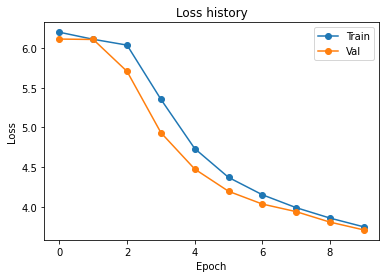

In [367]:
plt.plot(hist["loss_train"], "o-")
plt.plot(hist["loss_val"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")

plt.show()

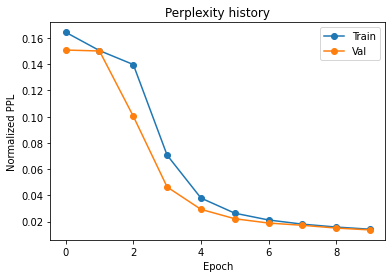

In [368]:
plt.plot(hist["ppl_train"]/vocab_size, "o-")
plt.plot(hist["ppl_val"]/vocab_size, "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Normalized PPL")
plt.title("Perplexity history")

plt.show()

In [374]:
raise ValueError

ValueError: 

## Avaliação

A avaliação é realizada calculando a perplexidade do modelo no conjunto de teste. É calculada apenas a perplexidade do melhor modelo nos dados de validação, para reportar a capacidade de generalização do modelo:

In [ ]:
test_loss = compute_loss(model, test_loader, criterion)
test_ppl = ppl(test_loss)

test_ppl.item()

Calculamos também a quantidade total de parâmetros utilizados pelo modelo:

In [404]:
n_param = sum([p.numel() for p in model.parameters()])
n_param

585912

## Exemplo de uso

Para uso do modelo, definimos uma função para gerar mais texto até obter o tamanho máximo:

In [402]:
def generate_text(model:torch.nn.Module, vocab:Dict, inverse_vocab:List, text:str, max_length:int) -> str:
    """
    Generates a text to complete the previous.

    Args:
        model (torch.nn.Module): language model to use.
        vocab (Dict): vocabulary. Maps words to codes.
        inverse_vocab (List): inverse vocabulary. Maps codes to words.
        text (str): text to complete.
        max_length (int): maximum length to obtain.

    Returns:
        str: generated text.
    """

    text = clean_text(text)

    total_length = len(text.split(" "))

    last_sequence = create_sequences([text], context_size, vocab)[-1][1:]
    last_sequence = torch.tensor(last_sequence)-1
    last_sequence = last_sequence.to(device)

    new_characters = []

    while total_length < max_length:
                
        output = model(torch.unsqueeze(last_sequence, 0))

        next_encoded = output[0][-1].argmax()

        last_sequence = torch.cat((last_sequence[1:], torch.tensor([next_encoded]).to(device)))
        
        new_characters.append(next_encoded.item())

        total_length += 1

    new_characters = np.array(new_characters)+1

    new_text = " ".join(decode_sentence(new_characters, inverse_vocab))

    return new_text

E geramos um texto de exemplo.

In [403]:
text = cleaned_paragraphs[200]#300]
max_length = 70

new_text = generate_text(model, vocab, inverse_vocab, text, max_length)

print("OLD")
print(text)
print("")
print("GENERATED CONTINUATION")
print(new_text)

OLD
nesse instante erguia a cabeça e fitava os olhos n'uma sebe de folhas que se elevava a vinte passos de distancia , e se

GENERATED CONTINUATION
de novo ao rio , e o italiano , e de novo ao mesmo tempo , e o italiano , e de um homem de sua senhora , e a sua senhora , e a sua senhora , e a sua senhora , e a sua


É perceptível como que o modelo rapidamente colapsa para uma sequência fixa.